# 0. Introduction

This notebook analyses the predictions of the neural network

1) we will retrain the model for 2000 epochs

2) we will analyse the prediction errors of the neural network

3) we will use SHAP to identify the important variables for the neural network

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 16.1 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras import layers, regularizers
import shap

In [ ]:
sns.set_theme(palette="colorblind", rc={'figure.figsize':(14, 10)})

# 1. Data

In [ ]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/ML in M&A/modelling_data.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
# select all the row other than deal price as independent variables
X = df.iloc[:, 2:]
# select log deal price as target
y = df.iloc[:, 1]

In [ ]:
# create a train test split
X_train_dev, X_test, y_train_dev, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# create a development set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_dev, y_train_dev, test_size=0.2, random_state=42)

In [ ]:
y_train.mean()

435092146.6025237

In [ ]:
y_dev.mean()

333863601.31738037

In [ ]:
y_test.mean()

589108973.4133065

In [ ]:
# transform the data to be zero-mean and unit-variance normalized
ss = StandardScaler()
ss.fit(X_train)
X_train_trans = ss.transform(X_train)
X_dev_trans = ss.transform(X_dev)
X_test_trans = ss.transform(X_test)

# 2. Neural network

Re-create and retrain the model

In [ ]:
# function to plot the results
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([1e8, 5e8])
  plt.xlabel('Epoch')
  plt.ylabel('Error [deal_price]')
  plt.legend()
  plt.grid(True)

In [ ]:
# define model structure (these values are found by the bayesian optimization)
optimal_model = keras.Sequential([
                          layers.InputLayer(input_shape=(38,)), 
                          layers.Dense(37, activation="relu", kernel_regularizer=regularizers.l2(0.00001)),
                          layers.Dense(1)
])

In [ ]:
# compile model (these values are found by the bayesian optimization)
optimal_model.compile(
    optimizer=tf.keras.optimizers.RMSprop(0.1),
    loss='mae',
    metrics=['mae']
)

In [ ]:
# train model
epochs = 2_000

history = optimal_model.fit(
    x=X_train_trans,
    y=y_train,
    validation_data=(X_dev_trans, y_dev),
    epochs=epochs
)

Epoch 1/2000
50/50 [==============================] - 4s 7ms/step - loss: 435089536.0000 - mae: 435089536.0000 - val_loss: 333856800.0000 - val_mae: 333856800.0000
Epoch 2/2000
50/50 [==============================] - 0s 3ms/step - loss: 435078816.0000 - mae: 435078816.0000 - val_loss: 333843328.0000 - val_mae: 333843328.0000
Epoch 3/2000
50/50 [==============================] - 0s 3ms/step - loss: 435061120.0000 - mae: 435061120.0000 - val_loss: 333823552.0000 - val_mae: 333823552.0000
Epoch 4/2000
50/50 [==============================] - 0s 3ms/step - loss: 435037024.0000 - mae: 435037024.0000 - val_loss: 333797952.0000 - val_mae: 333797952.0000
Epoch 5/2000
50/50 [==============================] - 0s 3ms/step - loss: 435006336.0000 - mae: 435006336.0000 - val_loss: 333766144.0000 - val_mae: 333766144.0000
Epoch 6/2000
50/50 [==============================] - 0s 3ms/step - loss: 434968704.0000 - mae: 434968704.0000 - val_loss: 333728512.0000 - val_mae: 333728512.0000
Epoch 7/2000
50/

In [ ]:
optimal_model.save("/content/drive/MyDrive/Colab Notebooks/ML in M&A/optimal_model_2000epochs.h5")

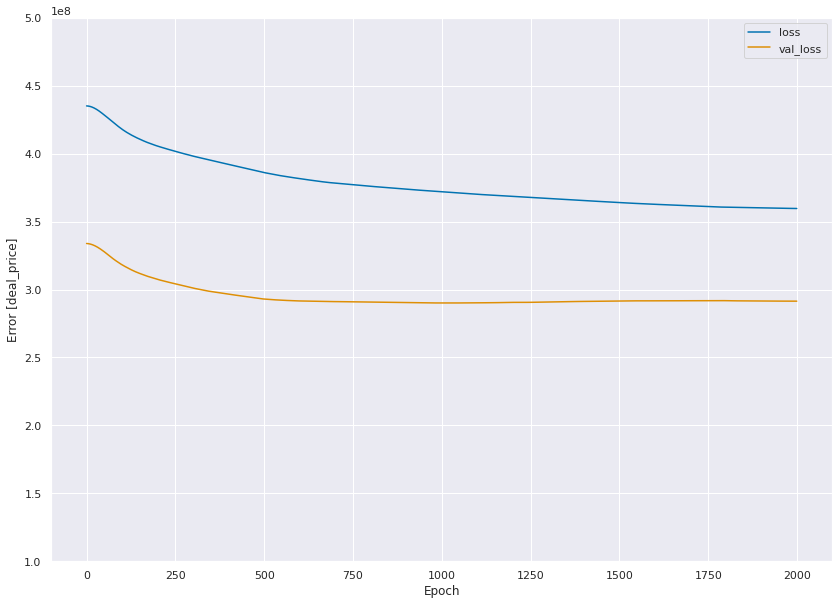

In [ ]:
plot_loss(history)

# 3. Prediction errors

In [ ]:
def compute_mae(model, X, y):
  pred = model.predict(X)
  return mean_absolute_error(y, pred)

In [ ]:
def plot_prediction_results(model, X, y, title1, title2):
    pred = model.predict(X)
    absolute_errors = abs(np.subtract(y.to_numpy(), np.concatenate(pred, axis=0)))
    fig, axs = plt.subplots(ncols=2, figsize=(20,10))
    sns.histplot(x=absolute_errors, ax=axs[0]).set(title=title1)
    sns.regplot(x=np.concatenate(pred, axis=0), y=y, ax=axs[1]).set(title=title2)

## 3.1. MAE

In [ ]:
# MAE for train set
compute_mae(optimal_model, X_train_trans, y_train)

359574295.5288052

In [ ]:
# MAE for dev set
compute_mae(optimal_model, X_dev_trans, y_dev)

291410452.1882995

In [ ]:
# MAE for test set
compute_mae(optimal_model, X_test_trans, y_test)

529953181.11994195

## 3.2. Error distributions

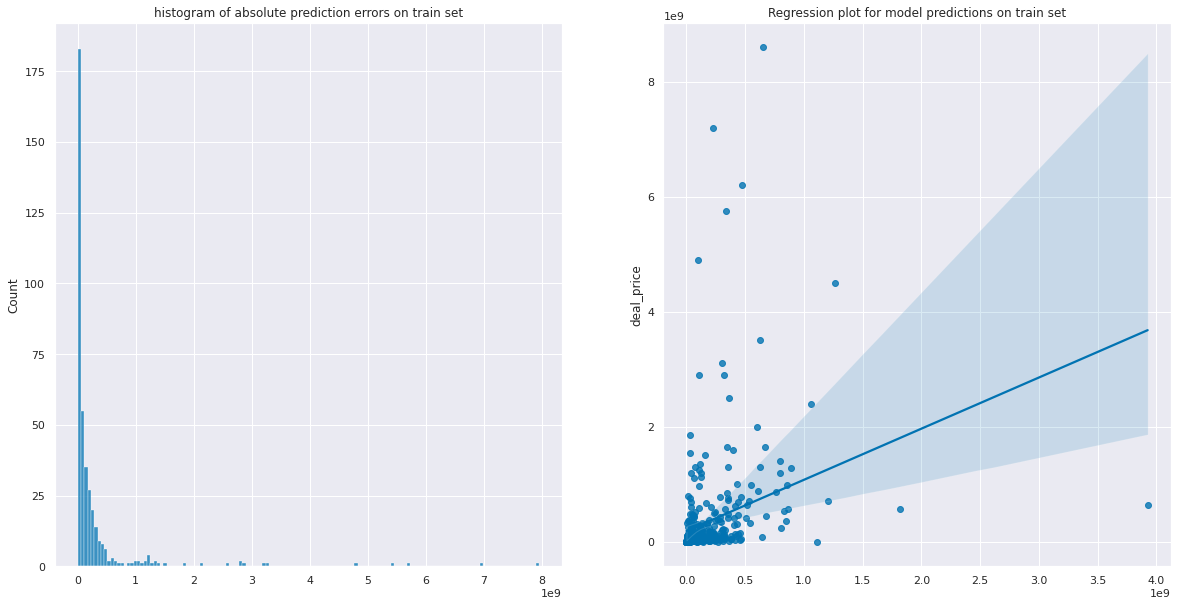

In [ ]:
plot_prediction_results(optimal_model, X_dev_trans, y_dev, 'histogram of absolute prediction errors on train set', 'Regression plot for model predictions on train set')
plt.savefig('NN predictions on train')

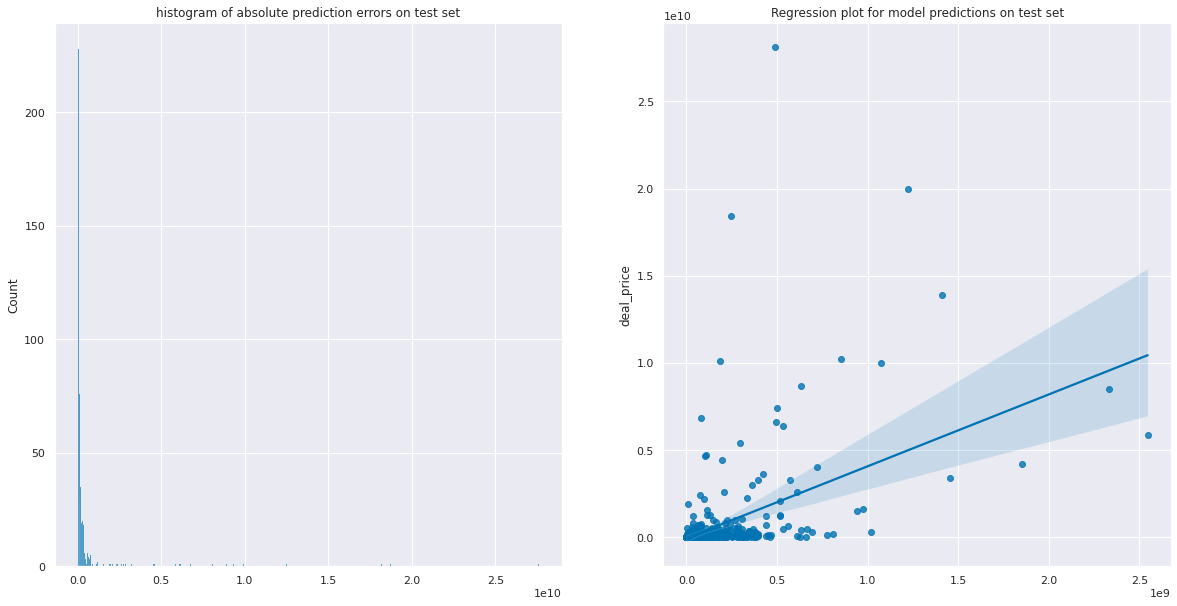

In [ ]:
plot_prediction_results(optimal_model, X_test_trans, y_test, 'histogram of absolute prediction errors on test set', 'Regression plot for model predictions on test set')
plt.savefig('NN predictions on test')

# 4. SHAP

In [ ]:
background = X_train_trans[np.random.choice(X_train_trans.shape[0], 500, replace=False)]

In [ ]:
explainer = shap.KernelExplainer(optimal_model.predict, background)
shap_values = explainer.shap_values(X_test_trans, nsamples=100)

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/496 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: 

In [ ]:
# baseline prediction if the model has no information
explainer.expected_value

array([1.53553761e+08])

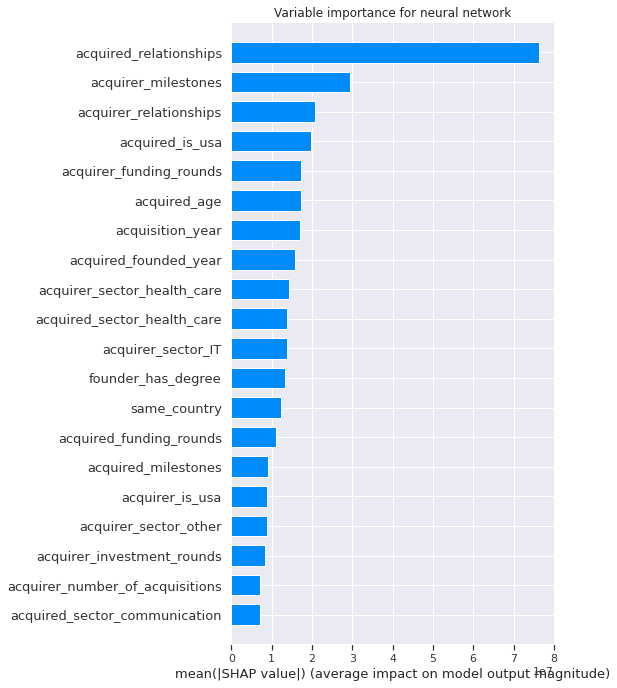

In [ ]:
shap.summary_plot(shap_values[0], X_test_trans, feature_names=X_test.columns, plot_type='bar', show=False)
plt.title('Variable importance for neural network')
plt.savefig('Variable importance for neural network', bbox_inches='tight')
plt.show()

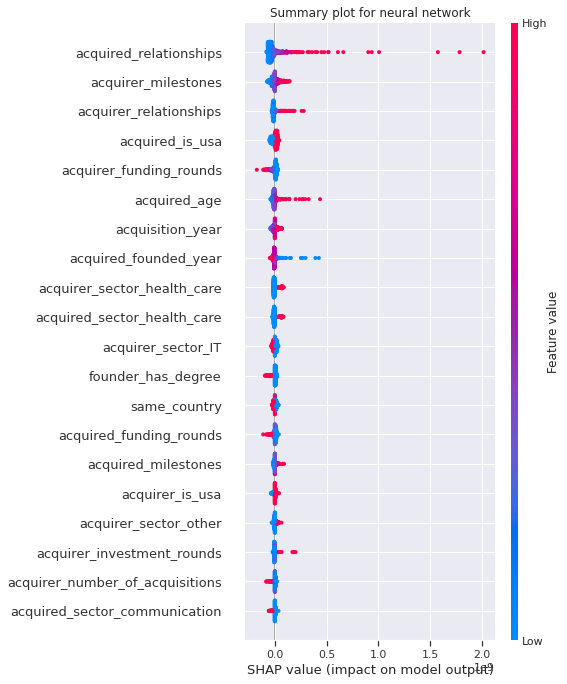

In [ ]:
shap.summary_plot(shap_values[0], X_test_trans, feature_names=X_test.columns, show=False)
plt.title('Summary plot for neural network')
plt.savefig('Summary plot for neural network', bbox_inches='tight')
plt.show()